In [40]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns

In [3]:
# DAG
dag = [
     None, # dummy
     {'depends': [], 'duration': 4},
     {'depends': [1], 'duration': 4},
     {'depends': [1], 'duration': 2},
     {'depends': [2], 'duration': 5},
     {'depends': [2], 'duration': 2},
     {'depends': [3], 'duration': 3},
     {'depends': [3], 'duration': 2},
     {'depends': [3], 'duration': 3},
     {'depends': [5, 6, 7], 'duration': 2},
     {'depends': [4, 8, 9], 'duration': 2},
]

for i, task in enumerate(dag):
    if task is not None:
        print("Task {}: duration: {}, depends on {}".format(i, task['duration'], task['depends']))

Task 1: duration: 4, depends on []
Task 2: duration: 4, depends on [1]
Task 3: duration: 2, depends on [1]
Task 4: duration: 5, depends on [2]
Task 5: duration: 2, depends on [2]
Task 6: duration: 3, depends on [3]
Task 7: duration: 2, depends on [3]
Task 8: duration: 3, depends on [3]
Task 9: duration: 2, depends on [5, 6, 7]
Task 10: duration: 2, depends on [4, 8, 9]


In [12]:
def simulate(n, dag):
    samples = [None]
    for task in dag:
        if task is not None:
            samples.append(np.random.exponential(task['duration'], n))
   
    times = np.zeros((len(dag), n))
    for i, task in enumerate(dag):
        if task is not None:
            if task['depends']:
                times[i, :] = np.max(times[task['depends'], :] + samples[i], axis=0)
            else:
                times[i, :] = samples[i]
            
    df = pd.DataFrame(times).transpose()
    df.columns = ['task_' + str(x) for x in df.columns]
    return df
        
simulate(10, dag)

,task_0,task_1,task_2,task_3,task_4,task_5,task_6,task_7,task_8,task_9,task_10
0,0.0,0.123234,3.385093,1.806569,4.127237,5.685393,2.199468,2.306571,5.382048,7.448816,8.424434
1,0.0,7.850029,8.961804,10.383312,9.837482,9.472508,12.635855,10.791266,12.450494,13.012404,15.930956
2,0.0,19.221342,20.636998,21.287383,32.158166,26.521186,21.350677,21.511821,21.826739,26.651422,32.822541
3,0.0,2.747180,4.608497,5.817421,5.158043,6.358662,11.681969,6.966276,8.086207,20.466996,22.357320
4,0.0,8.926747,9.994014,13.475334,10.537577,10.011928,14.356705,13.806509,18.695063,22.111092,22.160427
5,0.0,0.121744,1.554850,2.220765,1.846796,2.853401,2.659042,3.030876,13.306372,3.178260,17.894028
6,0.0,2.012740,7.770902,7.579602,8.990333,8.459753,8.084487,16.898214,10.584759,16.960275,18.171415
7,0.0,0.121939,11.931025,0.461582,14.667830,15.212226,6.842382,1.859419,6.476899,17.649572,19.322365
8,0.0,0.596964,3.245643,2.387189,5.471538,3.781530,8.717195,5.094182,2.654191,9.906134,11.733220
9,0.0,2.808174,8.858601,4.566526,13.802397,10.357323,6.620882,5.141166,8.571181,10.903601,14.430692


,N,count,ratio
0,1000,0,0.000000
1,10000,0,0.000000
2,50000,2,0.000040
3,100000,5,0.000050
4,500000,25,0.000050
5,1000000,36,0.000036
6,5000000,173,0.000035


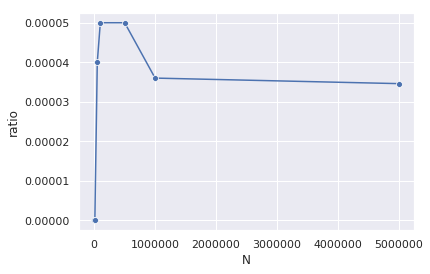

In [52]:
# Number of times we go over 70 day time limit at different time limitsA
trials = []
for N in [1000, 10000, 50000, 100000, 500000, 1000000, 5000000]:
    df = simulate(N, dag)
    count = len(df[df.task_10 >= 70])
    trials.append({'N': N, 'count': count, 'ratio': count / len(df)})
                  
trials = pd.DataFrame(trials)
#print('(N=%07d): %d; %.7f' % (N, count, count / len(df)))
display(trials)
sns.lineplot(x='N', y='ratio', data=trials, markers=True, marker='o')